In [4]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch_v2 import Net
# from compare_performance import compare_performance
from branch_NPP24 import Net_NPP24
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchaudio version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Wed Nov 20 18:04:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:21:00.0  On |                  Off |
| 46%   60C    P8             21W /  140W |    6420MiB /  16376MiB |      5%      Default |
|                                         |                        |                  N/A |
+-------------

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    disable_branch_NPP23=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

#    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    fname = f"{fname}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error, branch_NPP23 = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_total_runtime = []
    branch_NPP23_fdb_runtime, branch_NPP23_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_hi, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_runtime.append(branch_total_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )
            
        ######### NPP23 Deep branching method
        if not disable_branch_NPP23:
            torch.manual_seed(seed)
            print(
                f"#### Starting NPP23 deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model_NPP23 = Net_NPP23(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model_NPP23.train_and_eval(debug_mode)
            branch_NPP23_total_runtime.append(time.time() - start)
            branch_NPP23_fdb_runtime.append(model_NPP23.fdb_runtime)
            branch_NPP23_runtime.append(branch_NPP23_total_runtime[-1] - branch_NPP23_fdb_runtime[-1])
            tmp = (
                model_NPP23(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch_NPP23 += tmp
            branch_NPP23_l1_error.append((np.abs(tmp - true)).mean())
            branch_NPP23_l2_error.append(((tmp - true) ** 2).mean())
            branch_NPP23_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_NPP23_runtime[-1]:.0f} seconds; L1 error: {branch_NPP23_l1_error[-1]:.2E}; L2 error: {branch_NPP23_l2_error[-1]:.2E}; rel error: {branch_NPP23_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_NPP23_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_NPP23_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_total_runtime = np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )
            
    if not disable_branch_NPP23:
        branch_NPP23 /= len(seeds)
        branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error = (
            np.array(branch_NPP23_runtime),
            np.array(branch_NPP23_l1_error),
            np.array(branch_NPP23_l2_error),
            np.array(branch_NPP23_rel_error),
        )
        branch_NPP23_fdb_runtime, branch_NPP23_total_runtime = np.array(
            branch_NPP23_fdb_runtime
        ), np.array(branch_NPP23_total_runtime)
        print("\n")
        print("######## Summary for NPP23 deep branching method")
        print(f"runtime:        {branch_NPP23_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_NPP23_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_NPP23_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_NPP23_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_NPP23_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_NPP23_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_NPP23_l2_error.std():.2E}")
        print(f"mean rel error: {branch_NPP23_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_NPP23_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch_NPP23, label="NPP23 Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch_NPP23, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.grid()
    fname = f"{fname}_dim_{dim}" if fname is not None else f"demo_dim_{dim}"
    plt.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    plt.show()
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

## Allen-Cahn equation in dimension d = 1 with T = 0.5

In [5]:
fixed_dim, dim = 0, 1

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return y - y ** 3

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -5.*math.sqrt(dim), 5.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 100 seconds; L1 error: 2.47E-03; L2 error: 1.48E-05; rel error: 8.58E-03.
total runtime: 100 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 85 seconds; L1 error: 1.92E-03; L2 error: 6.88E-06; rel error: 5.70E-03.
fdb runtime: 0 seconds; total runtime: 85 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 68 seconds; L1 error: 2.84E-03; L2 error: 1.12E-05; rel error: 2.99E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 117 seconds; L1 error: 5.37E-03; L2 error: 5.36E-05; rel error: 5.53E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 102 seconds; L1 error: 5.20E-03; L2 error: 7.68E-05; rel error: 1.11E-02.
total runtime: 102 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 86 seconds; L1 error: 1.97E-03; L2 er

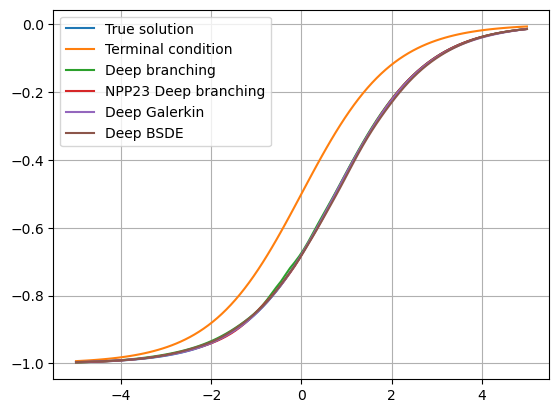

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    # disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen-cahn",
                    branch_nb_states=10000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Allen-Cahn equation in dimension d = 10 with T = 0.5

In [7]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 236 seconds; L1 error: 2.20E-03; L2 error: 1.35E-05; rel error: 1.28E-02.
total runtime: 236 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 138 seconds; L1 error: 2.02E-03; L2 error: 1.01E-05; rel error: 2.63E-02.
fdb runtime: 0 seconds; total runtime: 138 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 244 seconds; L1 error: 9.30E-03; L2 error: 1.25E-04; rel error: 2.02E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 126 seconds; L1 error: 4.33E-03; L2 error: 2.97E-05; rel error: 2.88E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 243 seconds; L1 error: 2.71E-03; L2 error: 1.62E-05; rel error: 1.93E-02.
total runtime: 243 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 134 seconds; L1 error: 2.11E-03; L

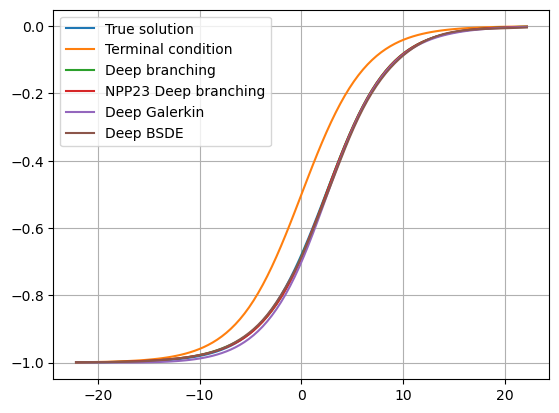

In [8]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    # disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen-cahn",
                    branch_nb_states=10000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Allen-Cahn equation in dimension d = 100 with T = 0.5

In [9]:
fixed_dim, dim = 0, 100

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 1491 seconds; L1 error: 5.87E-03; L2 error: 7.31E-05; rel error: 3.58E-02.
total runtime: 1491 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 337 seconds; L1 error: 4.87E-03; L2 error: 6.59E-05; rel error: 2.51E-02.
fdb runtime: 0 seconds; total runtime: 337 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 218 seconds; L1 error: 3.97E-03; L2 error: 2.74E-05; rel error: 1.08E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 1470 seconds; L1 error: 6.23E-03; L2 error: 9.09E-05; rel error: 2.91E-02.
total runtime: 1470 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 335 seconds; L1 error: 5.88E-03; L2 error: 6.60E-05; rel error: 5.68E-02.
fdb runtime: 0 seconds; total runtime: 335 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 

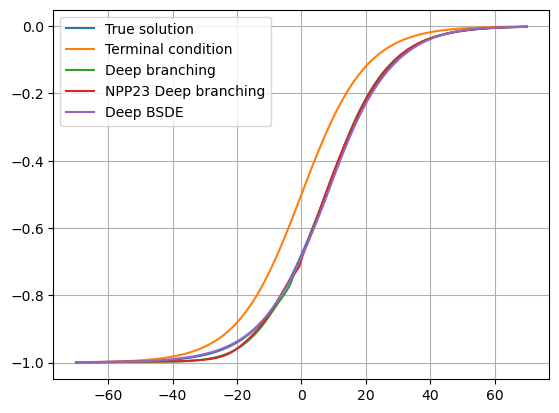

In [10]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    disable_galerkin=True, # disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen-cahn",
                    branch_nb_states=10000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Allen-Cahn equation in dimension d = 300 with T = 0.5

In [11]:
fixed_dim, dim = 0, 300

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 547 seconds; L1 error: 9.29E-03; L2 error: 1.71E-04; rel error: 4.44E-02.
total runtime: 547 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 96 seconds; L1 error: 9.59E-03; L2 error: 1.78E-04; rel error: 4.76E-02.
fdb runtime: 0 seconds; total runtime: 96 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 491 seconds; L1 error: 4.81E-03; L2 error: 4.07E-05; rel error: 1.38E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 535 seconds; L1 error: 9.63E-03; L2 error: 1.79E-04; rel error: 4.05E-02.
total runtime: 535 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 97 seconds; L1 error: 9.00E-03; L2 error: 1.51E-04; rel error: 6.21E-02.
fdb runtime: 0 seconds; total runtime: 97 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Ti

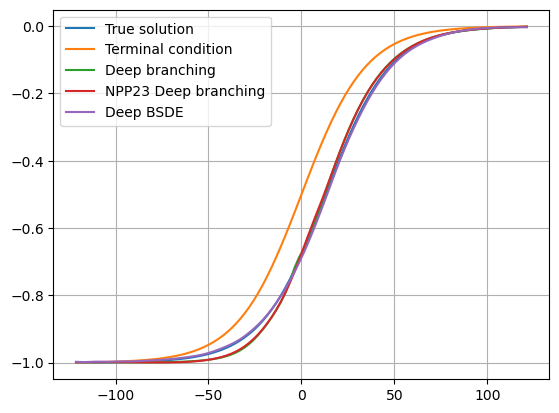

In [12]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    disable_galerkin=True, # disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen-cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Allen-Cahn equation in dimension d = 500 with T = 0.5

In [13]:
fixed_dim, dim = 0, 500

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -5.*math.sqrt(dim), 5.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 1137 seconds; L1 error: 1.28E-02; L2 error: 2.38E-04; rel error: 3.83E-02.
total runtime: 1137 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 140 seconds; L1 error: 1.32E-02; L2 error: 2.51E-04; rel error: 3.83E-02.
fdb runtime: 0 seconds; total runtime: 140 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 725 seconds; L1 error: 6.68E-03; L2 error: 6.34E-05; rel error: 4.23E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 1085 seconds; L1 error: 1.37E-02; L2 error: 2.65E-04; rel error: 4.30E-02.
total runtime: 1085 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 1.31E-02; L2 error: 2.41E-04; rel error: 4.35E-02.
fdb runtime: 0 seconds; total runtime: 146 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 

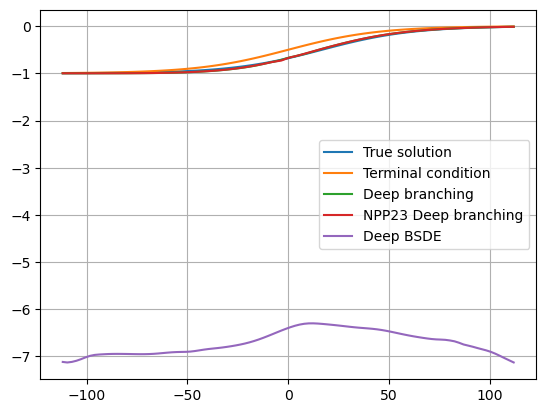

In [14]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, disable_branch_NPP23=True, 
                    disable_galerkin=True, # disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)